# DSI Motor Screening
Use this notebook to look through the motor imagery data collected using the DSI-7 (2018.12.18).

In [1]:
from matplotlib import pyplot as plt
import scipy.signal as scisig
import numpy as np
import pandas as pd
import csv

Function to convert .easy files from NIC2 (recording software for Enobio) to Pandas dataframe

## Load the EEG data
Load in the data from the NIC2 .easy file and convert to a Pandas dataframe

In [2]:
filename = '../data/nile_motor_screening_raw.csv'

In [3]:
EEGmeta = list()

# Open and read ('r') csv file with raw data
with open(filename, 'r') as csvfile:
    for row in range(0,15):
        EEGmeta.append(csvfile.readline())

# Save sampling frequency
fs = int(EEGmeta[1].split(',')[1])

# Skip the first 15 rows that contain the meta data
EEGdata = pd.read_csv(filename,',',skiprows=15)

# Preview
EEGdata.head()

,Time,Oz,F4,C4,PO8,PO7,C3,F3,Trigger,Time_Offset,ADC_Status,ADC_Sequence,Event,Comments
0,0.0033,-1028.1,1433.7,376.8,-1484.1,-651.6,-128.4,-1586.1,0,6,0,235,0,NaN
1,0.0067,-1016.1,1438.2,386.4,-1474.5,-635.1,-111.9,-1583.7,0,12,0,236,0,NaN
2,0.0100,-993.3,1442.4,395.7,-1458.6,-606.6,-88.5,-1525.8,0,18,0,237,0,NaN
3,0.0133,-945.9,1459.8,404.7,-1431.6,-540.0,-36.6,-1320.3,0,24,0,238,0,NaN
4,0.0167,-978.9,1423.5,389.7,-1451.7,-587.7,-80.1,-1396.5,0,30,0,239,0,NaN


In [4]:
# Check shape of the data
np.shape(EEGdata)

(220246, 14)

In [5]:
# Create the time array
time = np.linspace(0, np.shape(EEGdata)[0]/fs, np.shape(EEGdata)[0])

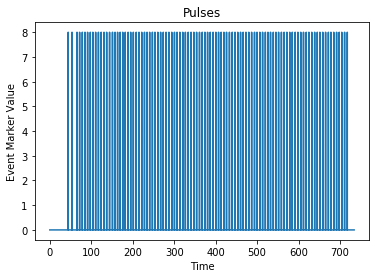

In [6]:
# Plot
plt.figure()
plt.plot(time, EEGdata['Trigger'])
plt.xlabel('Time')
plt.ylabel('Event Marker Value')
plt.title('Pulses')
plt.show()

In [7]:
# Check pulse value(s)
np.unique(EEGdata['Trigger'])

array([0, 8], dtype=int64)

Plot all channel data

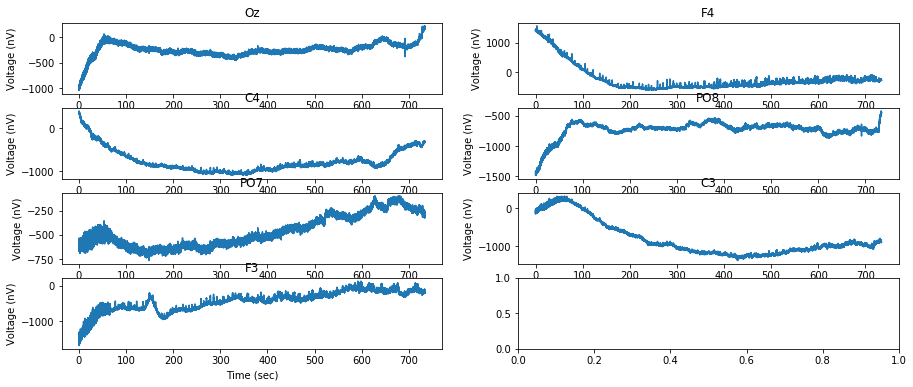

In [8]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
for chanOfInt in EEGdata.columns[1:8]:
    axs[i].plot(time, EEGdata[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

Plot event marker data

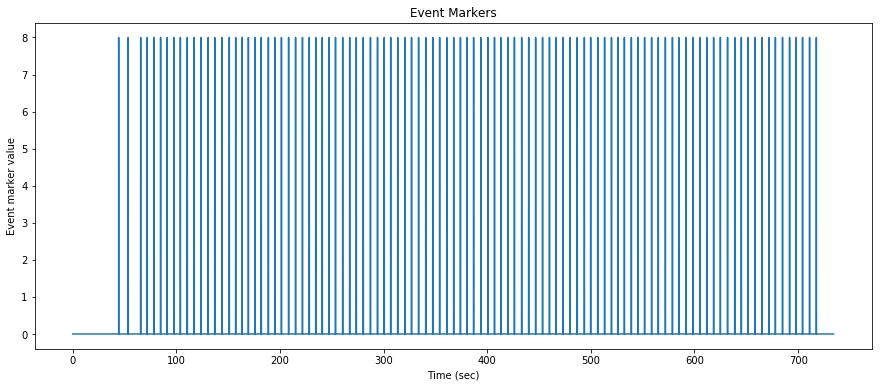

In [9]:
plt.figure(figsize=(15,6))
plt.plot(time, EEGdata['Trigger'])
plt.xlabel('Time (sec)')
plt.ylabel('Event marker value')
plt.title('Event Markers')
plt.show()

## Load the behavioral data

In [10]:
behavioral_file = '../data/nile_Motor_Screening_R1.csv'
behavioralData = pd.read_csv(behavioral_file, ',')
behavioralData = behavioralData.transpose()

# Saving header information
behavioralHeader = behavioralData.iloc[0]

behavioralData = behavioralData.iloc[2:]
behavioralData.columns = behavioralHeader
behavioralData.head()

Unnamed: 0,trialStart,stimulus,trialLength,trialType
trial_0,12.168064150493592,Imagine moving your left hand,5,B
trial_1,18.41341136454139,Move your right hand,5,C
trial_2,24.92969827534398,Move your left hand,5,A
trial_3,31.38418420800008,Imagine moving your left hand,5,B
trial_4,37.680190290731844,Move your left hand,5,A


### Sync up event markers / trigger pulses
Note that for the DSI-7, we sound audio beeps that are sent as pulses through the trigger hub and are recorded with the EEG. For the Enobio, we use Lab Streaming Layer (LSL) to send direct pulses with integer values to the recording software.

In [11]:
# Store where the values in trigger are equal to 8 (the audio trigger input channel number)
index_trigger = np.where(EEGdata['Trigger']==8)
t0 = index_trigger[0][0]

# Initial peak/jump detection (note that it isn't clean all the time so just take initial)
index_trigger = np.where(np.diff(EEGdata['Trigger'])>1) #use EEGdata['Trigger'] to make sure we get initial

In [12]:
# Delete suspicious trigger pulses that are closer than 4 seconds to one another
index_trigger = np.delete(index_trigger, np.where(np.diff(index_trigger[0]) < (4*fs)))

# Remove initial sync pulse (there were two in this case)
index_trigger = index_trigger[2:]

index_trigger.shape

(100,)

Get the trial and rest start and end times

In [13]:
trialLength = 5

# Get trial timing
t_trial_start = list()
t_trial_end = list()

# Check number of trials
num_of_trials = behavioralData.shape[0]

# Creating lists of all trigger start and end locations
for i in range(0,num_of_trials):
    t_trial_start.append(index_trigger[i])
    t_trial_end.append(index_trigger[i] + int(trialLength*fs))

# Save rest period epochs as well as trials for comparison
t_rest_start = list()
t_rest_end = list()

for i in range(num_of_trials-1):
    t_rest_start.append(t_trial_end[i])
    t_rest_end.append(t_trial_start[i+1])

## Cleaning the EEG data
Artifact removal and filtering

In [14]:
from mne.filter import filter_data

In [15]:
EEGdata_filt = EEGdata.copy()
channels = EEGdata.columns[1:8]

eeg_data = EEGdata[channels].values * 1.0 # multiply by 1.0 to convert int to float
filtered = filter_data(eeg_data.T, sfreq=fs, l_freq=1, h_freq=40)
EEGdata_filt[channels] = filtered.T

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 991 samples (3.303 sec) selected


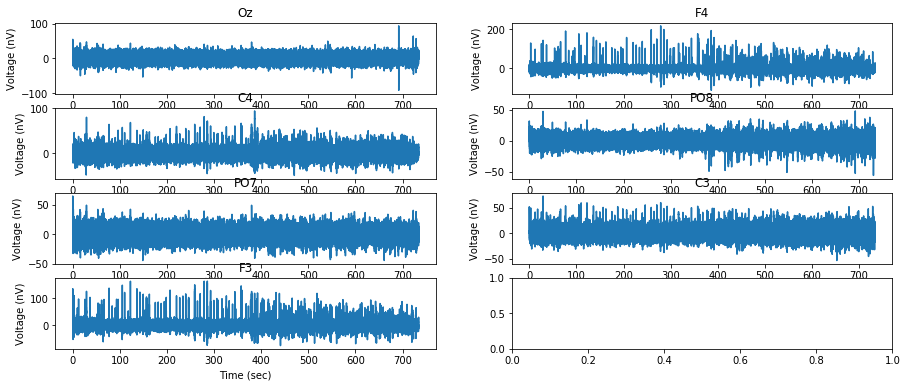

In [16]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
channels = EEGdata.columns[1:8]

for chanOfInt in channels:
    axs[i].plot(time, EEGdata_filt[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

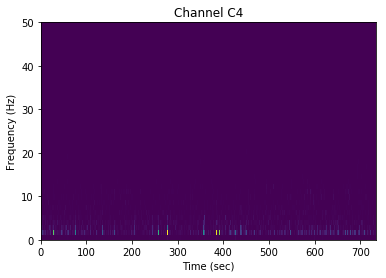

In [17]:
chanOfInt = 'C4'
f, t, Sxx = scisig.spectrogram(EEGdata_filt[chanOfInt], fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0,50])
plt.title('Channel ' + chanOfInt)
plt.show()

## Epoch and visualize the data
Separate the data by trials (cleaned "raw" data and frequency information) and visually inspect the time-frequency information for the trial conditions. Does power in any particular band look consistently different for math vs non-math trials?

In [18]:
epochs_raw = []
epochs_filt = []

for trial in range(0,len(t_trial_start)):
    epochs_raw.append(EEGdata.loc[t_trial_start[trial]:t_trial_end[trial]][channels])
    epochs_filt.append(EEGdata_filt.loc[t_trial_start[trial]:t_trial_end[trial]][channels])

In [19]:
# This ends up returning a list of dataframes where df[trial number][channels]
epochs_raw[0].head()

,Oz,F4,C4,PO8,PO7,C3,F3
19663,-46.5,502.2,-474.6,-708.0,-482.4,247.2,-623.4
19664,-68.7,494.4,-489.9,-719.4,-514.5,225.3,-679.5
19665,-81.0,501.0,-490.2,-727.2,-533.4,220.5,-712.2
19666,-53.1,501.9,-484.2,-724.5,-511.5,235.8,-695.7
19667,-78.9,501.9,-483.9,-724.8,-522.3,241.2,-670.5


In [20]:
# See how many trials we have
len(epochs_raw)

100

A useful link on spectrogram settings https://stackoverflow.com/questions/43353172/producing-spectrogram-from-microphone/43454643

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


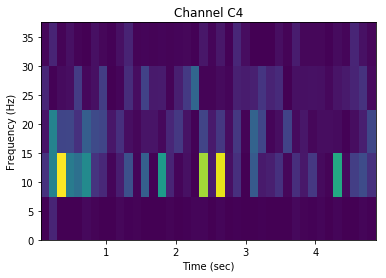

In [21]:
chanOfInt = 'C4'
trialOfInt = 15

ds_factor = 4 # downsampling factor
f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_raw[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)

# nperseg determines size of time bins, number of time bins = fs/nperseg - 1

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.title('Channel ' + chanOfInt)
plt.show()

## Organize by trial type
Create lists containing trial numbers for the different types of trials

| Trial Type | Movement      |
|------------|---------------|
| A          | Move Left     |
| B          | Imagine Left  |
| C          | Move Right    |
| D          | Imagine Right |
| E          | Rest          |

In [22]:
# Create lists for each trial type
trialA = list()
trialB = list()
trialC = list()
trialD = list()
trialE = list()
i = 0

for letter in behavioralData['trialType']:
    if letter == 'A':
        trialA.append(i)
    elif letter == 'B':
        trialB.append(i)
    elif letter == 'C':
        trialC.append(i)
    elif letter == 'D':
        trialD.append(i)
    elif letter == 'E':
        trialE.append(i)
    i += 1

print(trialA)

[2, 4, 9, 11, 16, 21, 22, 25, 29, 38, 40, 51, 63, 64, 75, 85, 86, 89, 91, 96]


In [23]:
# Create a single list that includes which trial is which
trial_type = list()
i = 0

for letter in behavioralData['trialType']:
    if letter == 'A':
        trial_type.append(0)
    elif letter == 'B':
        trial_type.append(1)
    elif letter == 'C':
        trial_type.append(2)
    elif letter == 'D':
        trial_type.append(3)
    elif letter == 'E':
        trial_type.append(4)
    i += 1

## Compare the data
Compare the average spectrograms for each type of trial

In [24]:
def PlotAverageSpectrogram(epochs, trials, chanOfInt, fs, ds_factor):
    """
    Input
    epochs: your data epochs (raw)
    trials: list or array of trials you wish to include in the average (e.g., all trials of type A)
    chanOfInt: name of the channel of interest
    fs: sampling rate
    ds_factor: downsampling factor
    """

    Sxx_all = list()

    for trialOfInt in trials:
        f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)
        # nperseg determines size of time bins, number of time bins = fs/nperseg - 1
        # nperseg = number of segments per second, so 10 = 100 ms chunks
        Sxx_all.append(Sxx)

    Sxx_avg = np.mean(Sxx_all,0)
    
    return f, t, Sxx_avg

### Plot

For left hand movement / motor imagery

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GU

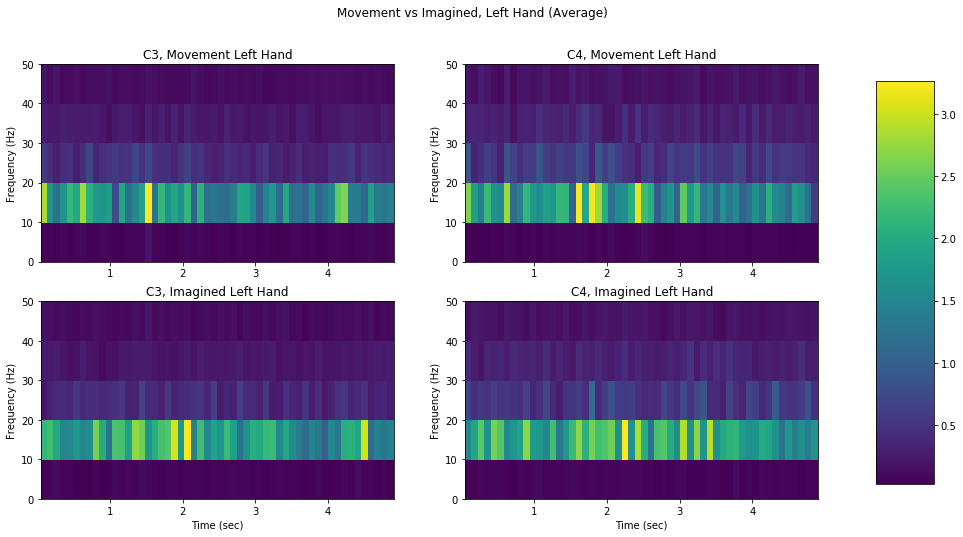

In [25]:
# Get average spectrogram values across trials
channelsOfInt = ['C3','C4','C3','C4']
trials = [trialA, trialA, trialB, trialB]
ds_factor = 3 # downsampling factor

# Set up for plotting
Nr = 2
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Movement vs Imagined, Left Hand (Average)')
i = 0

for ax in axes.flat:
    f, t, Sxx_avg = PlotAverageSpectrogram(epochs_raw, trials[i], channelsOfInt[i], fs, ds_factor)
    im = ax.pcolormesh(t, f, Sxx_avg)
    if i >=Nc:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Imagined Left Hand')
    else:
        ax.set_title(channelsOfInt[i] + ', Movement Left Hand')
    ax.set_ylabel('Frequency (Hz)')
    i += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()

For right hand movement / motor imagery

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GU

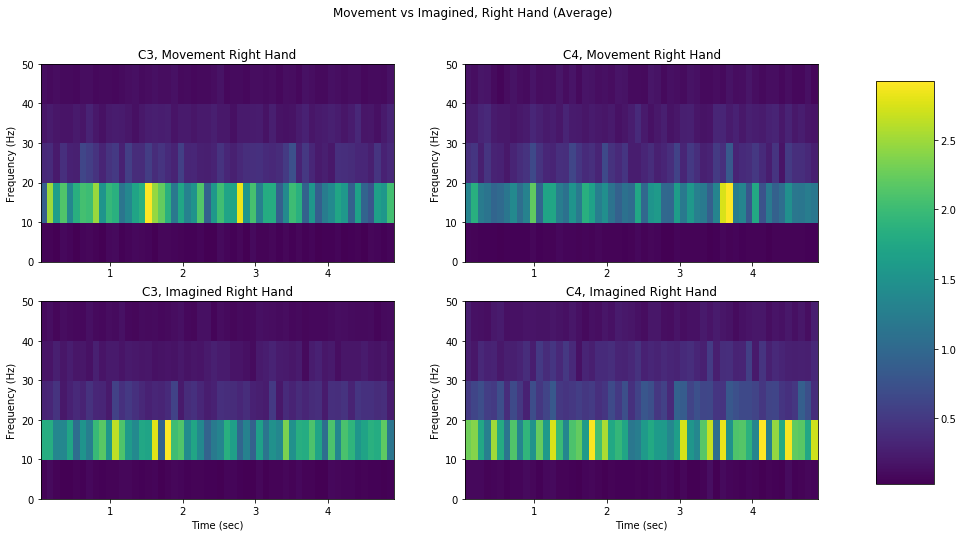

In [26]:
# Get average spectrogram values across trials
channelsOfInt = ['C3','C4','C3','C4']
trials = [trialC, trialC, trialD, trialD]
ds_factor = 3 # downsampling factor

# Set up for plotting
Nr = 2
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Movement vs Imagined, Right Hand (Average)')
i = 0

for ax in axes.flat:
    f, t, Sxx_avg = PlotAverageSpectrogram(epochs_raw, trials[i], channelsOfInt[i], fs, ds_factor)
    im = ax.pcolormesh(t, f, Sxx_avg)
    if i >=Nc:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Imagined Right Hand')
    else:
        ax.set_title(channelsOfInt[i] + ', Movement Right Hand')
    ax.set_ylabel('Frequency (Hz)')
    i += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()

Check rest trials as well

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GU

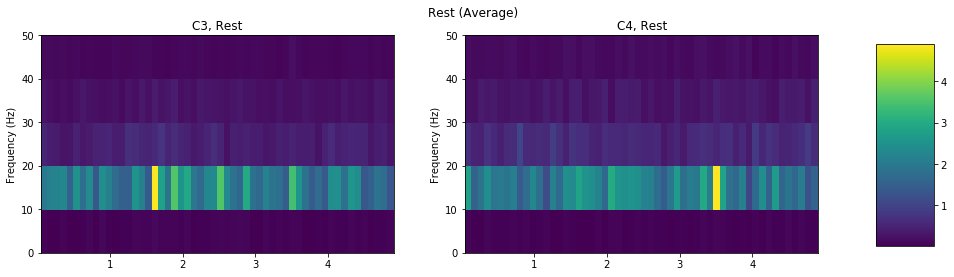

In [27]:
# Get average spectrogram values across trials
channelsOfInt = ['C3','C4']
trials = [trialE, trialE]
ds_factor = 3 # downsampling factor

# Set up for plotting
Nr = 1
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,4))
fig.suptitle('Rest (Average)')
i = 0

for ax in axes.flat:
    f, t, Sxx_avg = PlotAverageSpectrogram(epochs_raw, trials[i], channelsOfInt[i], fs, ds_factor)
    im = ax.pcolormesh(t, f, Sxx_avg)
    if i >=Nc:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Rest')
    else:
        ax.set_title(channelsOfInt[i] + ', Rest')
    ax.set_ylabel('Frequency (Hz)')
    i += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()

### Save the data

In [28]:
# Store spectrogram data for each trial, for each channel
ds_factor = 3 # downsampling factor
channels_to_use = channels # can also specify, like ['C3','C4']
epochs_Sxx = [[]]*len(channels_to_use)
i = 0

for chanOfInt in channels_to_use:
    tmp = list()
    for trial in range(0,len(trial_type)):
        f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_raw[trial][chanOfInt].T, ds_factor), fs/ds_factor, nperseg=10)
        tmp.append(Sxx.flatten('C')) # if you want all frequency data
        #tmp.append(Sxx[1]) # if you just want second frequency bin (10-20 Hz if you do ds_factor = 3)
    epochs_Sxx[i] = tmp
    i += 1

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [29]:
# Should be num of channels x num of trials x number of spectrogram data points
# So, 7 x 100 x 330
np.shape(epochs_Sxx)

(7, 100, 330)

## Classify epochs
See if you can reliably classify math vs non-math trials (reflecting differences in DMN activity)

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

Format the data to feed into a model

In [31]:
epochs_collapsed = []

# Concatenate all epochs such that shape is (num of trials x (flattened channels and spec data))
# So this should be 100 x 2310 (which is 7 channels * 330 spectrogram data points)
num_of_channels = np.shape(epochs_Sxx)[0]
num_of_trials = np.shape(epochs_Sxx)[1]
num_of_specData = np.shape(epochs_Sxx)[2]

epochs_collapsed = np.asarray(epochs_Sxx).reshape(num_of_trials, num_of_channels * num_of_specData)

In [32]:
# Double check we as many examples as we do number of trials
np.shape(epochs_collapsed)

(100, 2310)

In [33]:
# Assign your input and labels
X = epochs_collapsed
y = trial_type

# shuffle data to get train/test
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]

In [34]:
args

array([45, 55, 20, 53, 61, 46, 60, 38, 67, 41, 44, 86, 27, 73, 92, 36, 52,
       78, 75, 64, 66, 84, 21, 31, 17, 32, 58,  7,  2, 74, 90, 76, 87,  6,
       49, 85, 95, 15, 22, 71, 48,  4, 77, 63, 91, 40,  3, 18, 26, 72, 93,
       34, 37, 28, 29, 10, 16, 65, 51, 68, 14, 69,  8, 83,  9, 97, 35, 30,
       62, 39, 56, 80, 42, 81,  5, 98, 25, 13, 24, 79, 33,  1, 59, 82, 19,
       96, 99, 89,  0, 54, 11, 12, 23, 47, 50, 88, 70, 43, 57, 94])

In [35]:
# Separate into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Determine model parameters

In [36]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
hyper_params = {"C":C_range, "gamma":gamma_range}
grid = GridSearchCV(SVC(kernel='rbf', decision_function_shape='ovo'), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)

In [37]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 169 candidates, totalling 845 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 845 out of 845 | elapsed:   21.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]), 'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [38]:
grid.best_estimator_

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Fit the model

In [39]:
svc = SVC(kernel='rbf', C=100, degree=3, gamma=0.0001, verbose=True, decision_function_shape='ovo')
svc.fit(X_train, y_train)

[LibSVM]

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

### Evaluate

In [40]:
print('Using spectrogram data from all channels')
print('Training Score: ' + str(svc.score(X_train, y_train)))
print('Test Score: ' + str(svc.score(X_test, y_test)))

Using spectrogram data from all channels
Training Score: 1.0
Test Score: 0.2


Confusion matrix

Remember A = move left, B = imagine left, C = move right, D = imagine right, E = rest

| .        | Pred A | Pred B | Pred C | Pred D | Pred E |
|----------|--------|--------|--------|--------|--------|
| Actual A | TP     | .      | .      | .      | .      |
| Actual B | .      | TP     | .      | .      | .      |
| Actual C | .      | .      | TP     | .      | .      |
| Actual D | .      | .      | .      | TP     | .      |
| Actual E | .      | .      | .      | .      | TP     |

In [41]:
confusion_matrix(y_test, svc.predict(X_test))

array([[0, 2, 0, 0, 2],
       [0, 2, 1, 0, 2],
       [0, 1, 1, 1, 1],
       [0, 1, 2, 0, 1],
       [0, 1, 0, 1, 1]], dtype=int64)

### Visualize principal components

In [42]:
from mpl_toolkits.mplot3d import Axes3D

In [43]:
# Run PCA
pca = PCA(n_components=3)
results = pca.fit_transform(X)

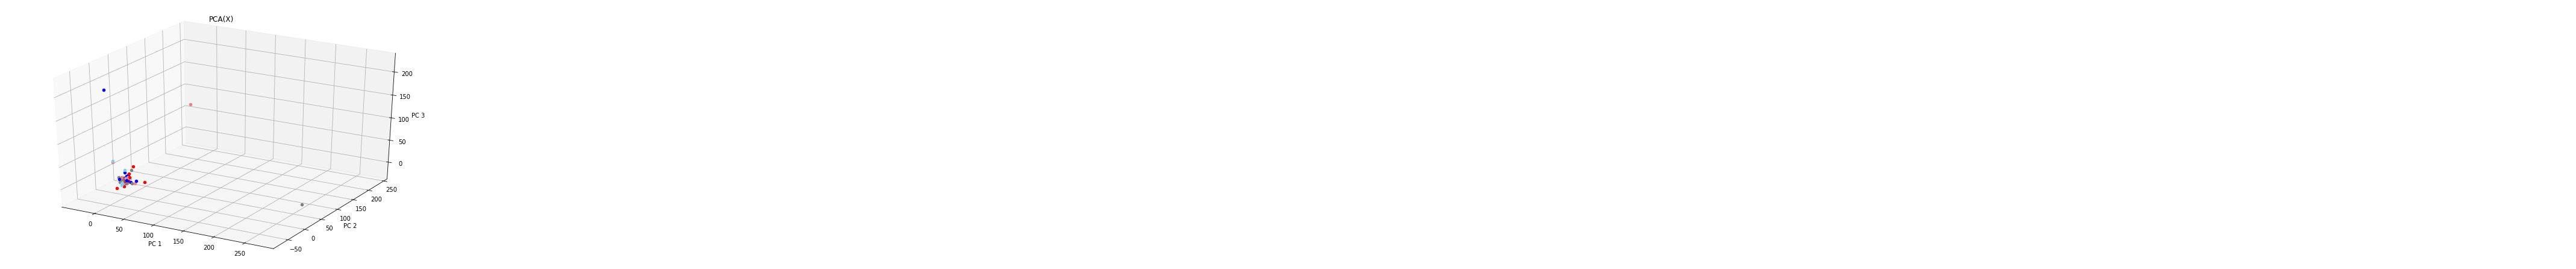

Blue = move left, Sky Blue = imagine left, Red = move right, Light Red = imagine right, Gray = Rest


In [44]:
# Plot
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
i=0
for num in y:
    # print(str(num))
    if num == 0:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='blue')
    elif num == 1:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='skyblue')
    elif num == 2:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='red')
    elif num == 3:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='lightcoral')
    elif num == 4:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='gray')
    i = i +1

ax.set_title('PCA(X)')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()
print('Blue = move left, Sky Blue = imagine left, Red = move right, Light Red = imagine right, Gray = Rest')